<a href="https://colab.research.google.com/github/Maspie/-Assignment/blob/main/Autoencoders%20and%20clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt




In [3]:
# Load the model without compiling (ignore the optimizer)
model_path = '/content/autoencoder_img/chestCNN_AutoEncoder300epoch.h5'
autoencoder = tf.keras.models.load_model(model_path, compile=False)

In [18]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize

# Path to the abnormal text file
abnormal_file_path = '/content/autoencoder_img/abnormal.txt'  # Update this path to your actual file

# Load the paths from the text file, skipping the first line
with open(abnormal_file_path, 'r') as f:
    abnormal_image_paths = f.readlines()[1:]

# Remove newline characters and define the base path
abnormal_image_paths = [path.strip() for path in abnormal_image_paths]

# Define the correct base folder (the one that contains the images)
base_folder = '/content/autoencoder_img/flip/'

# Construct the full paths correctly
abnormal_image_paths = [os.path.join(base_folder, os.path.basename(path.strip())) for path in abnormal_image_paths]

# Initialize lists to store errors and classifications
reconstruction_errors = []
classifications = []
threshold = 0.05  # Adjust threshold as needed

# Process each image using the constructed paths
for image_path in abnormal_image_paths:
    # Load and preprocess the image
    try:
        img = imread(image_path)  # Load image using the full path
        img_resized = resize(img, (256, 256))  # Resize to match model input size
        img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension

        # Predict using the autoencoder
        reconstructed_img = autoencoder.predict(img_resized)

        # Calculate reconstruction error
        error = np.mean(np.square(img_resized - reconstructed_img))
        reconstruction_errors.append(error)  # Store the error

        # Classify as normal or abnormal based on the threshold
        if error > threshold:
            classifications.append('abnormal')
            print(f"Image {image_path} is classified as abnormal (anomaly) with reconstruction error: {error:.4f}")
        else:
            classifications.append('normal')
            print(f"Image {image_path} is classified as normal with reconstruction error: {error:.4f}")

    except FileNotFoundError:
        print(f"File not found: {image_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image /content/autoencoder_img/flip/case246.tif is classified as abnormal (anomaly) with reconstruction error: 0.0515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image /content/autoencoder_img/flip/case245.tif is classified as abnormal (anomaly) with reconstruction error: 0.0616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image /content/autoencoder_img/flip/case244.tif is classified as abnormal (anomaly) with reconstruction error: 0.0527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image /content/autoencoder_img/flip/case243.tif is classified as normal with reconstruction error: 0.0459
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image /content/autoencoder_img/flip/case242.tif is classified as normal with reconstruction error: 0.0496
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image /content/autoencoder_img/flip/case241.tif is classified as abnormal (anomaly) with reconstruction error: 0.0655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image /content/autoencoder_img/flip/case240.tif is

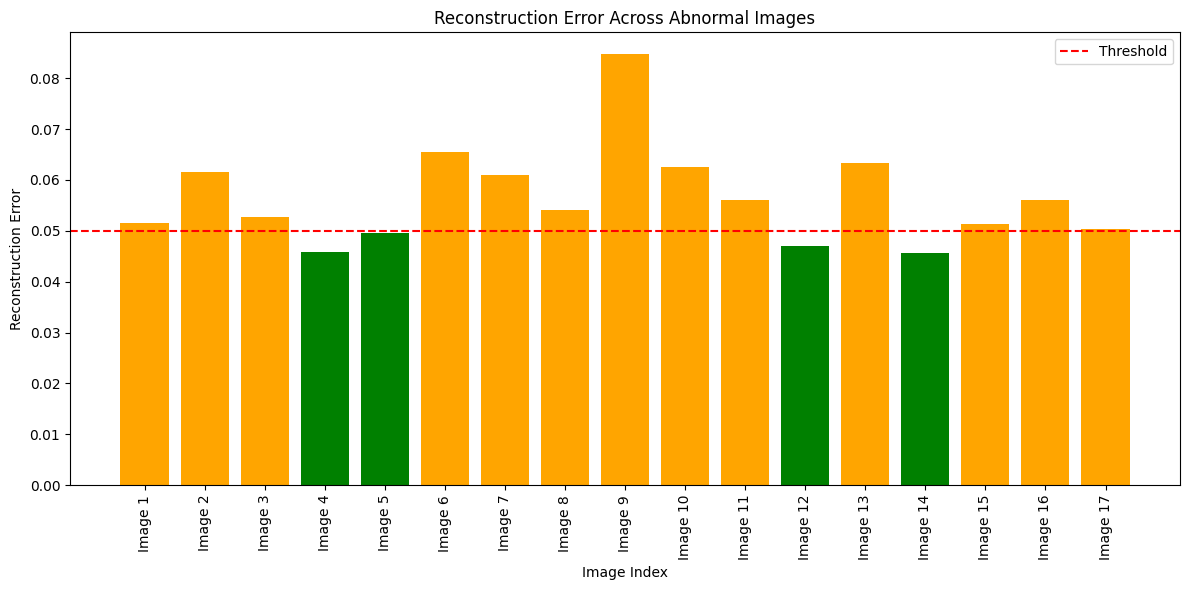

In [19]:
import matplotlib.pyplot as plt

# Check if reconstruction_errors and classifications are defined
if 'reconstruction_errors' in locals() and 'classifications' in locals():
    # Plotting the reconstruction errors
    plt.figure(figsize=(12, 6))
    colors = ['orange' if classification == 'abnormal' else 'green' for classification in classifications]

    plt.bar(range(len(reconstruction_errors)), reconstruction_errors, color=colors)
    plt.xlabel('Image Index')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error Across Abnormal Images')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.xticks(range(len(reconstruction_errors)), [f'Image {i+1}' for i in range(len(reconstruction_errors))], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Please ensure the previous cell has been run to define reconstruction_errors and classifications.")


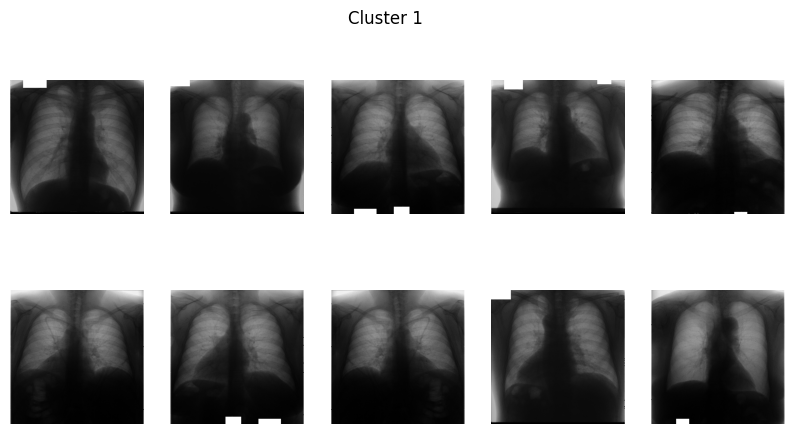

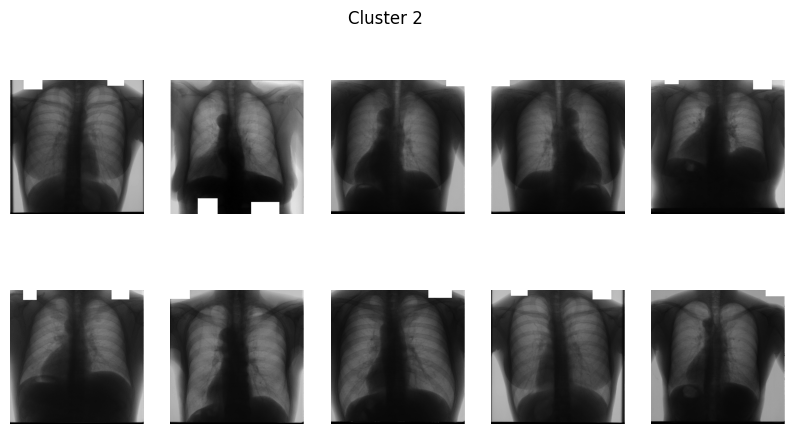

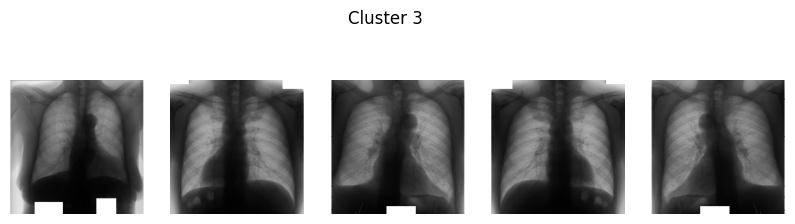

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(256, 256), color_mode='grayscale')
        img = img_to_array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

# Define autoencoder architecture
def build_autoencoder():
    input_img = Input(shape=(256, 256, 1))

    # Encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    decoded = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Main execution
folder = '/content/autoencoder_img/flip/'
images = load_images_from_folder(folder)

# Reshape for K-means (flatten images)
features = images.reshape(images.shape[0], -1)

# Train K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)  # Adjust n_clusters as needed
kmeans.fit(features)

# Get cluster labels
labels = kmeans.labels_

# Visualize clusters
for i in range(3):  # Change according to the number of clusters
    plt.figure(figsize=(10, 5))
    cluster_images = images[labels == i]
    for j in range(min(len(cluster_images), 10)):
        plt.subplot(2, 5, j + 1)
        plt.imshow(cluster_images[j].reshape(256, 256), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {i + 1}')
    plt.show()
